test_images/error-9.jpg
SEGMENTS LEN: 27
slopes: -0.80525460455 0.5
[[[190, 540, 475, 309]], [[936, 540, 475, 309]]]


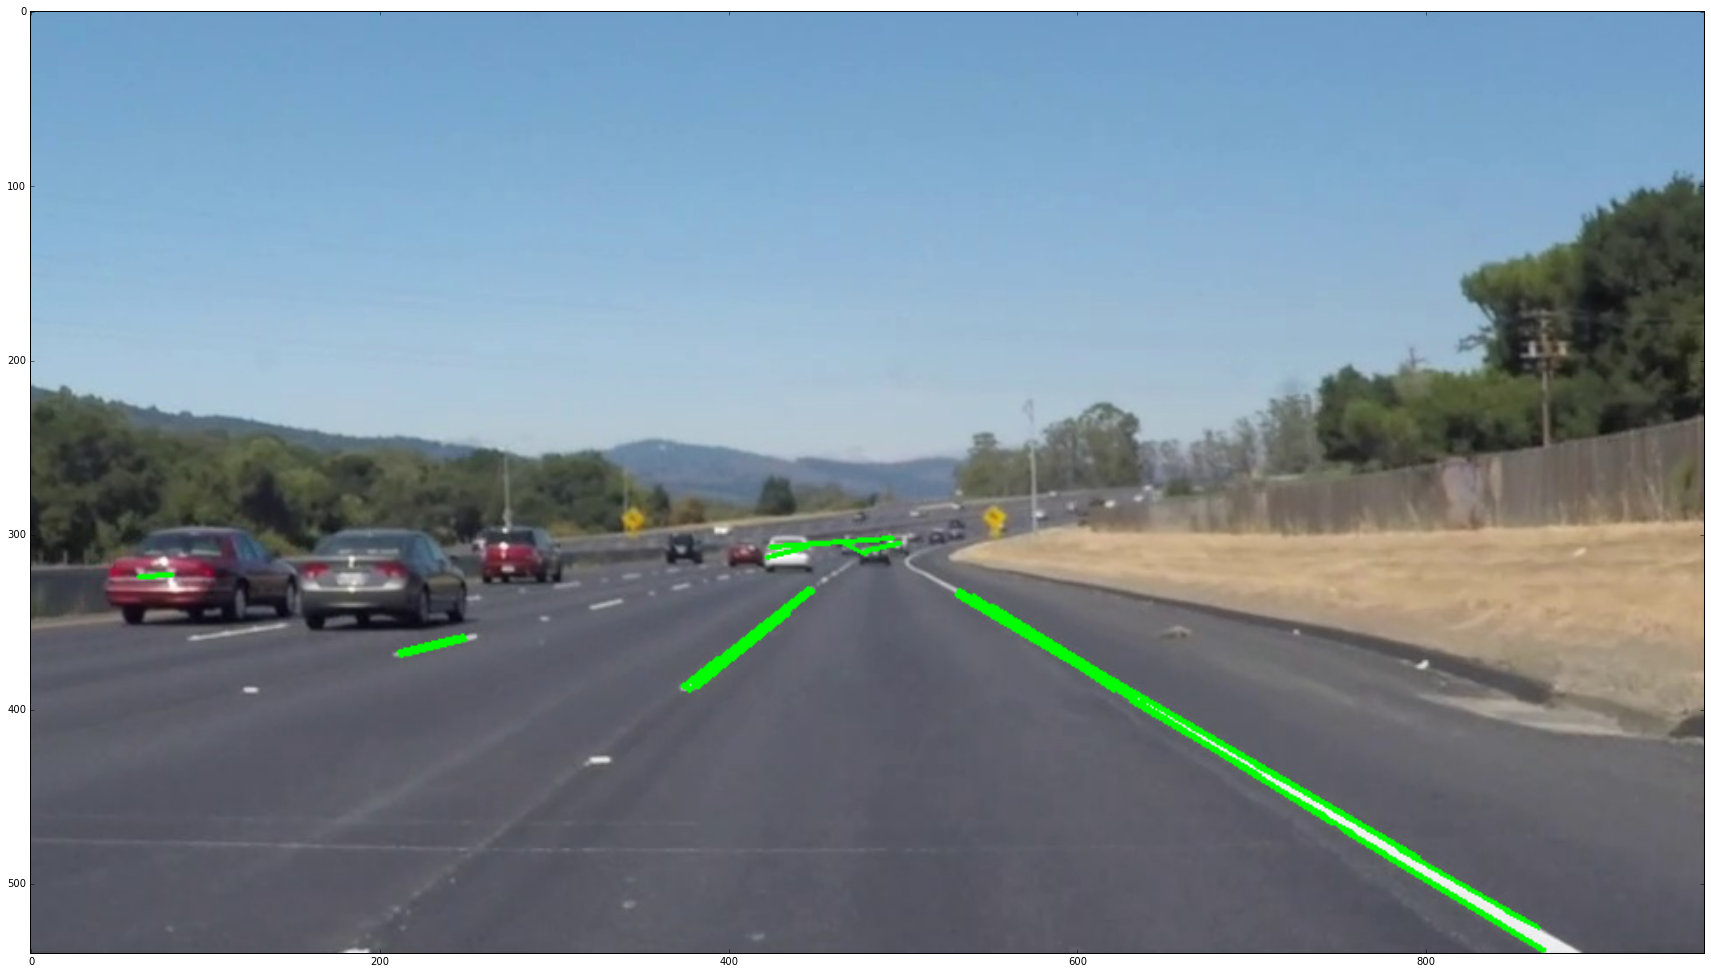

In [336]:
import math
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, color=[255,0,0]):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, color = color)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def lane_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)       
    ymask = cv2.inRange(hsv,  np.array([50, 100, 100]), np.array([100, 255, 255]))  
    wmask = cv2.inRange(image, np.array([200,200,200]), np.array([255,255,255]))
        
    mask = cv2.bitwise_or(ymask, wmask)
    res = cv2.bitwise_and(image, image, mask = mask)
    return res

def pass1(image):
    return grayscale(lane_mask(image))

def pass2(image):
    blur=7
    return gaussian_blur(image, blur)

def pass3(image):
    canny_low=10
    canny_high=30
    return canny(image, canny_low, canny_high)

def lines(image, draw=True, color=[255,0,0]):
    rho= 3 #distance in pixels
    theta=np.pi/180.0 #angle resolution of the acc in radians
    threshold=60
    min_line_len=10
    max_line_gap=40
    
    i = pass3(pass2(pass1(image)))
                
    if draw:         
        return hough_lines(i, rho, theta, threshold, min_line_len, max_line_gap, color = color)
    else:               
        return cv2.HoughLinesP(i, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
def slope(a):
    x1, y1, x2, y2 = a.reshape((4,))
    if x1 != x2:
        return (y2-y1)/(x2-x1)        
    else:
        return None
    
def bottom_x(a, y):
    s = slope(a)
    x1, y1, x2, y2 = a.reshape((4,))
    if s:
        return x1 + (y-y1)/s # x coordinate for line at given y
    else:
        #vertical line, x1 same as x2
        return x1

def intersection(lane1_x0, lane1_y0, lane1_slope, lane2_x0, lane2_y0, lane2_slope):
    y1 = 300 #any value could do
    print('slopes:', lane1_slope, lane2_slope)
    
    lane1_x1 = int(lane1_x0 + (y1 - lane1_y0)/lane1_slope)
    lane2_x1 = int(lane2_x0 + (y1 - lane2_y0)/lane2_slope)
    
    A1 = y1 - lane1_y0
    B1 = lane1_x0 - lane1_x1
    C1 = A1 * lane1_x0 + B1 * lane1_y0
    
    A2 = y1 - lane2_y0
    B2 = lane2_x0 - lane2_x1
    C2 = A2 * lane2_x0 + B2 * lane2_y0
    
    det = A1*B2 - A2*B1
    if det != 0:
        x2 = (B2*C1 - B1*C2)/det
        y2 = (A1*C2 - A2*C1)/det
        return [x2, y2]
    else:
        raise #parallel lines

        
def lane(segments, max_x, max_y, lane_x_range):    
    bin_pixels = 40
    num_bins = int(0.5 * max_x/bin_pixels)        

    # currently we use this range only to distinguish between left and right lanes
    # so the left lane is on the left-half of the x-axis
    lane_range = range(lane_x_range[0], lane_x_range[1])
    
    # calculate x-coordinate of intersection between extension of segment
    # and bottom line. 
    bottom = [bottom_x(x, max_y) for x in segments]
        
    if 0 == len([x for x in bottom if int(x) in lane_range]):
        print('NO SEGMENT in range', lane_range, bottom)
        #raise Exception("oops")
        
        
    # to find out whether each segments corresponds to a line
    counts, bins = np.histogram(bottom, bins=num_bins, range=lane_x_range)    
    #print(counts, bins)
    
    #TODO: handle empty sequence here, maybe repeat with different parameters.
    if len(counts) == 0:
        # debugging.
        #print('bin:', int(max_x/bin_width))
        #print('bottom:', bottom)        
        raise
     
    
    in_range = [i for i,v in enumerate(zip(counts, bins)) if v[0]>0 and int(v[1]) in lane_range]
    
    if 0 == len(in_range):
        #TODO
        print('#### failed here:')
        print('SEGMENTS', segments)        
        print('LANERANGE ', lane_range)
        print('HIST:', counts, bins)
        print('???', [v for i,v in enumerate(zip(counts, bins))])
    
    # the the x-bin with most occurrences -- all lines reaching this area will be averaged.
    i_left = max(in_range)
    llane_bin = range(int(bins[i_left]), int(bins[i_left+1]))        
    #print('bin:', llane_bin)
    #print('raw slopes:', [(slope(x),bottom_x(x, max_y)) for x in segments])
    
    # all slopes for lines reaching selected bin
    llane_slopes = [slope(x) for x in segments if int(bottom_x(x, max_y)) in llane_bin]
    llane_slopes = [x for x in llane_slopes if x is not None and abs(x)>0.1]
    
    # all x positions for lines reaching selected bin
    llane_xs = [int(bottom_x(x, max_y)) for x in segments]
    llane_xs = [x for x in llane_xs if x in llane_bin]
    #print('slopes:', llane_slopes)
    #print('xs:', llane_xs)
    
    # 
    # a lane is defined here by the slope and the position
    # on the line defined by y=max_y (bottom of the image)
    if len(llane_slopes)==0:
        #debugging
        print('LEN SLOPES ZERO.,,,,')
        print('BIN:', llane_bin)
        print('HISTT:', counts, bins)
        print('raw slopes:', [(slope(x),bottom_x(x, max_y)) for x in segments])        
    return np.mean(llane_slopes), np.mean(llane_xs)
    
def lanes(segments, max_x, max_y):   
    print('SEGMENTS LEN:', len(segments))
    left_slope, left_x = lane(segments, max_x, max_y, (0, 200)) # TODO
    right_slope, right_x = lane(segments, max_x, max_y, (760, 960)) # TODO
    #left lane: x0, y0, slope
    #right lane: x1, y1, slope
    horizon = intersection(left_x, max_y, left_slope, right_x, max_y, right_slope) 
    
    lines = []    
    lines.append([[int(left_x), int(max_y), int(horizon[0]), int(horizon[1])]])    
    lines.append([[int(right_x), int(max_y), int(horizon[0]), int(horizon[1])]])
    return lines

def lane_overlay(image):
    img2 = np.zeros_like(image)
    max_y = img2.shape[0]
    max_x = img2.shape[1]
    color = [200, 50, 255]
    color = [255, 0, 0]
    draw_lines(img2, lanes(lines(image, draw=False),  max_x, max_y), color = color, thickness=5)
    return img2
    
def sideBySide(filename):
    image=mpimg.imread(filename)            
    return np.hstack([image, weighted_img(lane_overlay(image), image)])    

def sideBySideDebug(filename):
    image=mpimg.imread(filename)            
    #return pass3(pass2(pass1(image)))
    return np.hstack([image, lane_mask(image), lines(image)])
    #return np.hstack([image, lane_mask(image), weighted_img(lane_overlay(image), image)])    

#filenames = ['test_images/' + f for f in os.listdir("test_images") if f.endswith('jpg')]
#filenames = [x for x in filenames if x.startswith('test_images/error')]
filenames = ['test_images/error-9.jpg']
for i, f in enumerate(filenames):
    print(f)
    #debug = sideBySideDebug(f)
    plt.figure(figsize=(30,30))    
    #plt.imshow(debug)

    image=mpimg.imread(f)            
    lines2 = [x for x in lines(image, draw=False)]    
    for row in lines2:
        l = row[0]
        #print(l)        
        cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,255,0), 2)    
    plt.imshow(image)
    print(lanes(lines2, 960, 540))
    #plt.imshow(pass2(pass1(image)))
    #plt.imshow(lane_mask(image))
        
    #image = mpimg.imread('test_images/' + f)
    #mage_with_lanes = weighted_img(image, lane_overlay(image))
    #lt.imshow(image_with_lanes)
    #mpimg.imsave('test_images/output/' + f, image_with_lanes)

    


In [276]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_debug = True 
error_count = 0

def process_image(image):  
    global error_count
    try:
        return weighted_img(image, lane_overlay(image))
    except ValueError:
        print('.')
        error_count += 1
        if process_debug:
            mpimg.imsave("test_images/error-{}.jpg".format(error_count), image)
        return image

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)


SEGMENTS LEN: 24
slopes: -0.75502550255 0.554397106466
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  1%|▏         | 3/222 [00:00<00:08, 26.99it/s]

SEGMENTS LEN: 24
slopes: -0.75502550255 0.554397106466
SEGMENTS LEN: 11
slopes: -0.799602250849 0.637319311513
SEGMENTS LEN: 12
slopes: -0.724137931034 0.55954248366


SEGMENTS LEN: 20
slopes: -0.80625 0.555
SEGMENTS LEN: 16
NO SEGMENT in range range(0, 480) [873.8780487804878, 850.35135135135135, 845.78260869565213, 880.84615384615381, 840.52941176470586, 843.46153846153845, 843.5, 890.75, 838.42105263157896, 847.0, 839.10714285714289, 847.73333333333335, 842.5, 885.39999999999998, 861.35294117647061, 879.0]
#### failed here:
SEGMENTS [[[729 452 864 534]]

 [[539 348 599 385]]

 [[756 481 791 504]]

 [[649 403 715 442]]

 [[535 344 588 378]]

 [[685 437 725 463]]

 [[737 469 779 497]]

 [[609 379 658 407]]

 [[611 391 640 410]]

 [[778 495 801 510]]

 [[700 445 741 473]]

 [[791 503 814 518]]

 [[727 463 757 483]]

 [[636 395 679 420]]

 [[672 429 701 446]]

 [[599 372 624 387]]]
BOTTOM(540) [873.8780487804878, 850.35135135135135, 845.78260869565213, 880.84615384615381, 840.52941176470586, 843.46153846153845, 843.5, 890.75, 838.42105263157896, 847.0, 839.10714285714289, 847.73333333333335, 842.5, 885.39999999999998, 861.35294117647061, 879.0]
LANERA





  2%|▏         | 5/222 [00:00<00:10, 20.03it/s]

SEGMENTS LEN: 9
slopes: -0.74053030303 0.565217391304
SEGMENTS LEN: 14
slopes: -0.738215488215 0.613552464223






  4%|▎         | 8/222 [00:00<00:10, 21.00it/s]

SEGMENTS LEN: 15
slopes: -0.722167487685 0.547297297297
SEGMENTS LEN: 10
slopes: -0.702495745888 0.576923076923
SEGMENTS LEN: 14
slopes: -0.738095238095 0.618847981492






  5%|▍         | 11/222 [00:00<00:09, 21.90it/s]

SEGMENTS LEN: 10
slopes: -0.726041666667 0.619534625534
SEGMENTS LEN: 16
slopes: -0.727833894501 0.644439340581






  6%|▋         | 14/222 [00:00<00:09, 22.70it/s]

SEGMENTS LEN: 23
slopes: -0.717409442409 0.621068427371
SEGMENTS LEN: 20
slopes: -0.762645107794 0.595105820106
SEGMENTS LEN: 23
slopes: -0.763645224172 0.614498227265






  8%|▊         | 17/222 [00:00<00:08, 23.58it/s]

SEGMENTS LEN: 12
slopes: -0.699490662139 0.620827192975
SEGMENTS LEN: 8
slopes: -0.65 0.616430200567
SEGMENTS LEN: 10
slopes: -0.68 0.675641666913






  9%|▉         | 20/222 [00:00<00:08, 24.15it/s]

SEGMENTS LEN: 17
slopes: -0.702922077922 0.613564290648
SEGMENTS LEN: 14
slopes: -0.685163563289 0.631224618281
SEGMENTS LEN: 12
slopes: -0.680496326286 0.661825789335






 10%|█         | 23/222 [00:00<00:08, 24.30it/s]

SEGMENTS LEN: 21
slopes: -0.745967741935 0.604790174252
SEGMENTS LEN: 10
slopes: -0.71186440678 0.643667541229
SEGMENTS LEN: 16
slopes: -0.681025139886 0.66962843338






 12%|█▏        | 26/222 [00:01<00:07, 25.15it/s]

SEGMENTS LEN: 19
slopes: -0.730158730159 0.624317793015
SEGMENTS LEN: 22
slopes: -0.753334417697 0.55
SEGMENTS LEN: 21
slopes: -0.736535069868 0.586206896552






 13%|█▎        | 29/222 [00:01<00:07, 25.98it/s]

SEGMENTS LEN: 17
slopes: -0.75 0.630388825734
SEGMENTS LEN: 12
slopes: -0.682142857143 0.629637481934
SEGMENTS LEN: 10
slopes: -0.6875 0.632001569478






 14%|█▍        | 32/222 [00:01<00:07, 25.97it/s]

SEGMENTS LEN: 15
slopes: -0.708850931677 0.633371649695
SEGMENTS LEN: 17
slopes: -0.739201269356 0.545454545455
SEGMENTS LEN: 16
slopes: -0.726136363636 0.606969990391






 16%|█▌        | 35/222 [00:01<00:07, 25.55it/s]

SEGMENTS LEN: 11
slopes: -0.777777777778 0.626439445791
SEGMENTS LEN: 14
slopes: -0.769476372925 0.605311337526






 17%|█▋        | 38/222 [00:01<00:07, 24.53it/s]

SEGMENTS LEN: 13
slopes: -0.72 0.628093245666
SEGMENTS LEN: 17
slopes: -0.734585323491 0.648026315789
SEGMENTS LEN: 20
slopes: -0.768013738745 0.631091943181


SEGMENTS LEN: 17
slopes: -0.728260869565 0.633737812517
SEGMENTS LEN: 13
slopes: -0.772759103641 0.565217391304






 18%|█▊        | 41/222 [00:01<00:07, 24.81it/s]

SEGMENTS LEN: 10
slopes: -0.652173913043 0.62488384973
SEGMENTS LEN: 7
slopes: -0.727272727273 0.631337768696
SEGMENTS LEN: 14
slopes: -0.726153846154 0.617615558199






 20%|█▉        | 44/222 [00:01<00:07, 22.77it/s]

SEGMENTS LEN: 12
slopes: -0.741935483871 0.645917368129


SEGMENTS LEN: 16
slopes: -0.718998410175 0.631517578078
SEGMENTS LEN: 17
slopes: -0.75 0.615967549472






 21%|██        | 47/222 [00:02<00:09, 18.22it/s]

SEGMENTS LEN: 8
slopes: -0.724814063556 0.655242718447
SEGMENTS LEN: 23
slopes: -0.75 0.646676522094






 22%|██▏       | 49/222 [00:02<00:09, 17.77it/s]

SEGMENTS LEN: 26
slopes: -0.75987394958 0.545454545455
SEGMENTS LEN: 22
slopes: -0.758620689655 0.55


SEGMENTS LEN: 19
slopes: -0.769230769231 0.633323170036






 23%|██▎       | 51/222 [00:02<00:13, 12.74it/s]

SEGMENTS LEN: 18
slopes: -0.712652129817 0.608463649387






 24%|██▍       | 53/222 [00:02<00:15, 11.08it/s]

SEGMENTS LEN: 9
slopes: -0.699470899471 0.648876287423
SEGMENTS LEN: 11
NO SEGMENT in range range(0, 480) [834.34210526315792, 849.10256410256409, 835.51351351351354, 856.8955223880597, 863.27272727272725, 831.66666666666663, 836.5625, 847.79999999999995, 837.86206896551721, 837.0, 857.41176470588232]
#### failed here:
SEGMENTS [[[535 345 710 459]]

 [[542 337 601 376]]

 [[696 451 754 488]]

 [[724 456 830 523]]

 [[698 439 734 461]]

 [[797 516 823 534]]

 [[562 349 585 365]]

 [[685 429 729 459]]

 [[684 443 730 472]]

 [[584 364 607 380]]

 [[808 510 836 527]]]
BOTTOM(540) [834.34210526315792, 849.10256410256409, 835.51351351351354, 856.8955223880597, 863.27272727272725, 831.66666666666663, 836.5625, 847.79999999999995, 837.86206896551721, 837.0, 857.41176470588232]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.


SEGMENTS LEN: 10
slopes: -0.714285714286 0.628290799588






 25%|██▍       | 55/222 [00:02<00:16,  9.86it/s]

SEGMENTS LEN: 9
slopes: -0.732886904762 0.634990024297






 26%|██▌       | 57/222 [00:03<00:18,  9.11it/s]

SEGMENTS LEN: 7
slopes: -0.658834586466 0.673368051021
SEGMENTS LEN: 12
slopes: -0.857142857143 0.65714392583
SEGMENTS LEN: 6
slopes: -0.711275314724 0.657074340528






 27%|██▋       | 59/222 [00:03<00:17,  9.32it/s]

SEGMENTS LEN: 10
slopes: -0.739538239538 0.606080016446






 27%|██▋       | 61/222 [00:03<00:15, 10.63it/s]

SEGMENTS LEN: 18
slopes: -0.690396557751 0.616256830601
SEGMENTS LEN: 19
slopes: -0.669140152195 0.649180327869
SEGMENTS LEN: 10
slopes: -0.679703103914 0.649659863946






 28%|██▊       | 63/222 [00:03<00:16,  9.82it/s]

SEGMENTS LEN: 13
slopes: -0.68894964043 0.625347458393
SEGMENTS LEN: 8
NO SEGMENT in range range(0, 480) [823.23636363636365, 845.69230769230762, 816.42105263157896, 823.14634146341461, 828.85714285714289, 824.36842105263156, 826.66666666666663, 820.15384615384619]
#### failed here:
SEGMENTS [[[618 404 701 459]]

 [[538 340 838 535]]

 [[532 347 588 385]]

 [[754 495 817 536]]

 [[750 492 773 506]]

 [[600 393 658 431]]

 [[759 498 788 516]]

 [[674 440 712 466]]]
BOTTOM(540) [823.23636363636365, 845.69230769230762, 816.42105263157896, 823.14634146341461, 828.85714285714289, 824.36842105263156, 826.66666666666663, 820.15384615384619]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.






 29%|██▉       | 65/222 [00:04<00:19,  8.17it/s]



 30%|██▉       | 66/222 [00:04<00:19,  7.97it/s]

SEGMENTS LEN: 10
NO SEGMENT in range range(0, 480) [847.0645161290322, 822.28735632183907, 821.74358974358972, 838.43478260869574, 847.73913043478262, 821.5, 818.75, 841.68965517241372, 847.3125, 843.90322580645159]
#### failed here:
SEGMENTS [[[538 339 824 525]]

 [[637 416 767 503]]

 [[760 497 816 536]]

 [[573 375 610 398]]

 [[785 501 822 524]]

 [[535 349 658 431]]

 [[761 498 783 514]]

 [[537 352 584 381]]

 [[752 479 802 511]]

 [[665 422 712 453]]]
BOTTOM(540) [847.0645161290322, 822.28735632183907, 821.74358974358972, 838.43478260869574, 847.73913043478262, 821.5, 818.75, 841.68965517241372, 847.3125, 843.90322580645159]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.
SEGMENTS LEN: 8
slopes: -0.620689655172 0.618173804512






 30%|███       | 67/222 [00:04<00:23,  6.47it/s]

SEGMENTS LEN: 10
slopes: -0.689655172414 0.650165016502
SEGMENTS LEN: 9
slopes: -0.672619047619 0.636513157895






 31%|███       | 69/222 [00:04<00:22,  6.80it/s]



 32%|███▏      | 71/222 [00:04<00:19,  7.57it/s]

SEGMENTS LEN: 12
slopes: -0.673469387755 0.632194081336
SEGMENTS LEN: 12
slopes: -0.777777777778 0.623072051787
SEGMENTS LEN: 14
slopes: -0.69014084507 0.632079332578






 33%|███▎      | 73/222 [00:05<00:18,  8.25it/s]

SEGMENTS LEN: 21
slopes: -0.734780388151 0.615694993412
SEGMENTS LEN: 18
slopes: -0.700113093971 0.630807177319






 34%|███▍      | 75/222 [00:05<00:17,  8.62it/s]

SEGMENTS LEN: 24
slopes: -0.711865021771 0.644020646021
SEGMENTS LEN: 15
slopes: -0.690879596251 0.647058823529






 35%|███▍      | 77/222 [00:05<00:17,  8.45it/s]

SEGMENTS LEN: 9
slopes: -0.676851851852 0.650177119979
SEGMENTS LEN: 11
NO SEGMENT in range range(0, 480) [817.91752577319585, 841.0, 834.27272727272725, 825.39999999999998, 823.71428571428578, 856.05882352941171, 836.68571428571431, 818.71428571428567, 855.68421052631584, 836.16216216216219, 824.60000000000002]
#### failed here:
SEGMENTS [[[525 342 812 536]]

 [[727 464 835 536]]

 [[651 414 715 458]]

 [[607 384 649 414]]

 [[629 399 658 420]]

 [[540 341 567 358]]

 [[707 451 758 486]]

 [[793 522 813 536]]

 [[532 335 562 354]]

 [[680 433 734 470]]

 [[595 376 637 406]]]
BOTTOM(540) [817.91752577319585, 841.0, 834.27272727272725, 825.39999999999998, 823.71428571428578, 856.05882352941171, 836.68571428571431, 818.71428571428567, 855.68421052631584, 836.16216216216219, 824.60000000000002]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.






 35%|███▌      | 78/222 [00:05<00:18,  7.83it/s]



 36%|███▌      | 79/222 [00:05<00:20,  6.83it/s]

SEGMENTS LEN: 7
slopes: -0.64367816092 0.69137581802
SEGMENTS LEN: 9
slopes: -0.694166666667 0.693352885926






 36%|███▌      | 80/222 [00:06<00:19,  7.32it/s]



 37%|███▋      | 82/222 [00:06<00:17,  8.22it/s]

SEGMENTS LEN: 12
slopes: -0.628571428571 0.679973122805
SEGMENTS LEN: 9
slopes: -0.702702702703 0.679581075732
SEGMENTS LEN: 7
slopes: -0.7 0.67451172373






 37%|███▋      | 83/222 [00:06<00:18,  7.69it/s]



 38%|███▊      | 85/222 [00:06<00:16,  8.10it/s]

SEGMENTS LEN: 9
slopes: -0.707593386405 0.667694683987
SEGMENTS LEN: 15
slopes: -0.67 0.601428571429






 39%|███▊      | 86/222 [00:06<00:16,  8.46it/s]



 39%|███▉      | 87/222 [00:06<00:16,  8.14it/s]

SEGMENTS LEN: 12
slopes: -0.678977272727 0.675939820064
SEGMENTS LEN: 21
slopes: -0.678899082569 0.5625






 40%|████      | 89/222 [00:07<00:14,  8.88it/s]

SEGMENTS LEN: 14
slopes: -0.701459793126 0.711092490463
SEGMENTS LEN: 10
slopes: -0.708333333333 0.689295686242
SEGMENTS LEN: 10
slopes: -0.85 0.666666666667






 41%|████      | 90/222 [00:07<00:16,  7.90it/s]



 41%|████▏     | 92/222 [00:07<00:13,  9.57it/s]

SEGMENTS LEN: 14
slopes: -0.68 0.637218045113
SEGMENTS LEN: 10
slopes: -0.65625 0.702591612392
SEGMENTS LEN: 7
slopes: -0.684210526316 0.70879439879






 42%|████▏     | 94/222 [00:07<00:14,  9.11it/s]



 43%|████▎     | 96/222 [00:07<00:12, 10.34it/s]

SEGMENTS LEN: 7
slopes: -0.673913043478 0.709430883723
SEGMENTS LEN: 16
slopes: -0.702346041056 0.666182315228
SEGMENTS LEN: 9
slopes: -0.663210227273 0.676103844383
SEGMENTS LEN: 13
slopes: -0.661458333333 0.720793713004






 44%|████▍     | 98/222 [00:07<00:12,  9.69it/s]

SEGMENTS LEN: 8
slopes: -0.683558558559 0.701433152446
SEGMENTS LEN: 7
slopes: -0.669565217391 0.720598372562
SEGMENTS LEN: 13
slopes: -0.669745649264 0.70386427225






 45%|████▌     | 100/222 [00:08<00:12,  9.61it/s]



 46%|████▌     | 102/222 [00:08<00:11, 10.76it/s]

SEGMENTS LEN: 8
slopes: -0.6875 0.710371027651
SEGMENTS LEN: 9
slopes: -0.695652173913 0.70255096568
SEGMENTS LEN: 10
slopes: -0.681428571429 0.716984342921






 47%|████▋     | 104/222 [00:08<00:11,  9.86it/s]

SEGMENTS LEN: 10
slopes: -0.741935483871 0.701715966334
SEGMENTS LEN: 11
slopes: -0.646464646465 0.664102564103
SEGMENTS LEN: 14
slopes: -0.697674418605 0.623108835609






 48%|████▊     | 106/222 [00:08<00:11,  9.73it/s]



 49%|████▊     | 108/222 [00:08<00:11,  9.99it/s]

SEGMENTS LEN: 12
slopes: -0.713636363636 0.659679416258
SEGMENTS LEN: 15
slopes: -0.699781829515 0.673115579229
SEGMENTS LEN: 17
slopes: -0.680088141026 0.661367852599






 50%|████▉     | 110/222 [00:09<00:11,  9.59it/s]

SEGMENTS LEN: 17
slopes: -0.676928541827 0.663866705
SEGMENTS LEN: 17
slopes: -0.687737753132 0.660346996896
SEGMENTS LEN: 16
slopes: -0.655279227368 0.640496086334






 50%|█████     | 112/222 [00:09<00:11,  9.60it/s]



 51%|█████▏    | 114/222 [00:09<00:10,  9.88it/s]

SEGMENTS LEN: 10
slopes: -0.657662835249 0.675208080052
SEGMENTS LEN: 5
NO SEGMENT in range range(0, 480) [843.94923857868025, 824.95833333333326, 821.20253164556959, -1647.0, -2880.0]
#### failed here:
SEGMENTS [[[545 339 838 536]]

 [[538 346 680 442]]

 [[687 447 801 526]]

 [[ 18 355  45 352]]

 [[ 15 347  45 345]]]
BOTTOM(540) [843.94923857868025, 824.95833333333326, 821.20253164556959, -1647.0, -2880.0]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.
SEGMENTS LEN: 11
slopes: -0.675729442971 0.675862068966






 52%|█████▏    | 116/222 [00:09<00:11,  9.26it/s]

SEGMENTS LEN: 10
slopes: -0.744927536232 0.674825174825
SEGMENTS LEN: 8
slopes: -0.671474358974 0.667365908387
SEGMENTS LEN: 10
slopes: -0.633928571429 0.675925925926






 53%|█████▎    | 118/222 [00:09<00:10,  9.79it/s]



 54%|█████▍    | 120/222 [00:10<00:10,  9.89it/s]

SEGMENTS LEN: 21
slopes: -0.643181818182 0.718383231542
SEGMENTS LEN: 12
slopes: -0.73 0.621282051282
SEGMENTS LEN: 19






 55%|█████▍    | 122/222 [00:10<00:09, 10.22it/s]

slopes: -0.682980983644 0.630885530931
SEGMENTS LEN: 17
slopes: -0.671727390016 0.640707751794
SEGMENTS LEN: 13
slopes: -0.688540572971 0.633866867337






 56%|█████▌    | 124/222 [00:10<00:09, 10.13it/s]

SEGMENTS LEN: 18
slopes: -0.703972427118 0.658341114223
SEGMENTS LEN: 13
slopes: -0.677221513605 0.631944590382
SEGMENTS LEN: 14
slopes: -0.565217391304 0.634363336733






 57%|█████▋    | 126/222 [00:10<00:10,  9.18it/s]



 58%|█████▊    | 128/222 [00:10<00:09, 10.12it/s]

SEGMENTS LEN: 10
slopes: -0.673913043478 0.654701372021
SEGMENTS LEN: 15
slopes: -0.708850289495 0.635975130682
SEGMENTS LEN: 16
slopes: -0.68431372549 0.610317612541






 59%|█████▊    | 130/222 [00:11<00:09,  9.90it/s]

SEGMENTS LEN: 13
slopes: -0.66038647343 0.609777435354
SEGMENTS LEN: 16
slopes: -0.715769230769 0.608901603206
SEGMENTS LEN: 15
slopes: -0.737648530331 0.634734533116






 59%|█████▉    | 132/222 [00:11<00:08, 10.63it/s]

SEGMENTS LEN: 14
slopes: -0.711111111111 0.60500362715
SEGMENTS LEN: 19
slopes: -0.69820971867 0.635181510031






 60%|██████    | 134/222 [00:11<00:09,  9.26it/s]



 61%|██████▏   | 136/222 [00:11<00:08,  9.57it/s]

SEGMENTS LEN: 17
slopes: -0.753540960016 0.645381864795
SEGMENTS LEN: 14
slopes: -0.727272727273 0.640885435953
SEGMENTS LEN: 16
slopes: -0.771428571429 0.606179738177






 62%|██████▏   | 138/222 [00:11<00:08, 10.26it/s]

SEGMENTS LEN: 12
slopes: -0.619047619048 0.55
SEGMENTS LEN: 9
slopes: -0.676883780332 0.639011237843






 63%|██████▎   | 140/222 [00:12<00:08,  9.87it/s]

SEGMENTS LEN: 9
slopes: -0.6875 0.663548116708
SEGMENTS LEN: 15
slopes: -0.666166166166 0.629385760836
SEGMENTS LEN: 12
slopes: -0.707317073171 0.572931276297






 64%|██████▍   | 142/222 [00:12<00:08,  9.79it/s]



 65%|██████▍   | 144/222 [00:12<00:07, 10.24it/s]

SEGMENTS LEN: 14
slopes: -0.730769230769 0.656930239901
SEGMENTS LEN: 11
slopes: -0.730158730159 0.655400552638
SEGMENTS LEN: 19
slopes: -0.742483235994 0.65177538114






 66%|██████▌   | 146/222 [00:12<00:07,  9.81it/s]

SEGMENTS LEN: 14
slopes: -0.706236275801 0.639382352464
SEGMENTS LEN: 21
slopes: -0.770439437106 0.557554945055
SEGMENTS LEN: 15
slopes: -0.730769230769 0.654132565217






 67%|██████▋   | 148/222 [00:12<00:07, 10.08it/s]



 68%|██████▊   | 150/222 [00:13<00:07, 10.11it/s]

SEGMENTS LEN: 19
slopes: -0.771196283391 0.591736694678
SEGMENTS LEN: 12
slopes: -0.6 0.631995812329
SEGMENTS LEN: 8
slopes: -0.785714285714 0.614080275985






 68%|██████▊   | 152/222 [00:13<00:06, 10.95it/s]

SEGMENTS LEN: 11
slopes: -0.831168831169 0.63311035453
SEGMENTS LEN: 16
slopes: -0.733199037547 0.589743589744






 69%|██████▉   | 154/222 [00:13<00:06, 10.29it/s]



 70%|███████   | 156/222 [00:13<00:06, 10.75it/s]

SEGMENTS LEN: 15
slopes: -0.68628185907 0.578268239114
SEGMENTS LEN: 14
slopes: -0.722222222222 0.551724137931
SEGMENTS LEN: 15
slopes: -0.727272727273 0.563370786517






 71%|███████   | 158/222 [00:13<00:06, 10.66it/s]

SEGMENTS LEN: 12
slopes: -0.752941176471 0.629750691751
SEGMENTS LEN: 13
slopes: -0.752212389381 0.585858585859
SEGMENTS LEN: 11
slopes: -0.762608353034 0.622978333409






 72%|███████▏  | 160/222 [00:14<00:05, 10.81it/s]

SEGMENTS LEN: 16
slopes: -0.779166666667 0.576051496738
SEGMENTS LEN: 14
slopes: -0.75 0.578673037706
SEGMENTS LEN: 6
NO SEGMENT in range range(0, 480) [886.32460732984293, 867.0, 863.60465116279067, 866.92857142857144, 862.17647058823536, 866.66666666666674]
#### failed here:
SEGMENTS [[[560 344 878 535]]

 [[567 360 732 459]]

 [[715 450 857 536]]

 [[689 434 736 462]]

 [[765 481 793 498]]

 [[660 416 700 440]]]
BOTTOM(540) [886.32460732984293, 867.0, 863.60465116279067, 866.92857142857144, 862.17647058823536, 866.66666666666674]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.






 73%|███████▎  | 162/222 [00:14<00:06,  9.84it/s]



 74%|███████▍  | 164/222 [00:14<00:06,  9.43it/s]

SEGMENTS LEN: 9
slopes: -0.681818181818 0.576381093486
SEGMENTS LEN: 10
slopes: -0.741935483871 0.603166570272






 74%|███████▍  | 165/222 [00:14<00:06,  9.18it/s]

SEGMENTS LEN: 11
slopes: -0.720588235294 0.5
SEGMENTS LEN: 17
slopes: -0.717575757576 0.5
SEGMENTS LEN: 13
slopes: -0.8125 0.560360316145






 75%|███████▌  | 167/222 [00:14<00:05,  9.51it/s]



 76%|███████▌  | 169/222 [00:15<00:05,  9.74it/s]

SEGMENTS LEN: 12
slopes: -0.76284638149 0.58238289176
SEGMENTS LEN: 22
slopes: -0.767156937006 0.555065624031
SEGMENTS LEN: 19
slopes: -0.740417263414 0.574467970476






 77%|███████▋  | 171/222 [00:15<00:05,  9.99it/s]

SEGMENTS LEN: 14
slopes: -0.770896801219 0.58016275142
SEGMENTS LEN: 22
slopes: -0.762023387023 0.561620887296






 78%|███████▊  | 173/222 [00:15<00:05,  9.24it/s]

SEGMENTS LEN: 10
slopes: -0.723188100381 0.572893891208
SEGMENTS LEN: 8
NO SEGMENT in range range(0, 480) [864.70085470085473, 886.71698113207549, 884.5, 853.49295774647885, 891.66666666666663, 883.27868852459017, 845.90909090909088, 893.36363636363637]
#### failed here:
SEGMENTS [[[662 419 858 536]]

 [[702 430 880 536]]

 [[550 339 773 473]]

 [[542 346 656 417]]

 [[844 514 866 526]]

 [[594 367 696 428]]

 [[611 388 645 410]]

 [[817 498 837 509]]]
BOTTOM(540) [864.70085470085473, 886.71698113207549, 884.5, 853.49295774647885, 891.66666666666663, 883.27868852459017, 845.90909090909088, 893.36363636363637]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.






 78%|███████▊  | 174/222 [00:15<00:05,  8.33it/s]



 79%|███████▉  | 176/222 [00:15<00:04,  9.38it/s]

SEGMENTS LEN: 16
slopes: -0.55 0.558620785661
SEGMENTS LEN: 10
slopes: -0.780448717949 0.580276918545
SEGMENTS LEN: 10
slopes: -0.78125 0.565143742825






 80%|████████  | 178/222 [00:15<00:04,  9.09it/s]

SEGMENTS LEN: 16
slopes: -0.788374498901 0.566724687187
SEGMENTS LEN: 16
slopes: -0.833333333333 0.572478048701
SEGMENTS LEN: 16
slopes: -0.821428571429 0.578026678314






 81%|████████  | 180/222 [00:16<00:04,  9.28it/s]



 82%|████████▏ | 182/222 [00:16<00:04,  9.85it/s]

SEGMENTS LEN: 15
slopes: -0.869565217391 0.611454840152
SEGMENTS LEN: 24
slopes: -0.809064058305 0.539863682269
SEGMENTS LEN: 21
slopes: -0.789715773947 0.574388564581






 83%|████████▎ | 184/222 [00:16<00:03,  9.88it/s]

SEGMENTS LEN: 12
slopes: -0.790104427736 0.579216618437
SEGMENTS LEN: 11
slopes: -0.78490990991 0.542857142857
SEGMENTS LEN: 11
NO SEGMENT in range range(0, 480) [889.23809523809518, 867.65263157894742, 886.81481481481478, 879.82352941176464, 880.71428571428578, 890.39999999999998, 881.0, 867.44000000000005, 884.85714285714289, 887.0, 881.66666666666663]
#### failed here:
SEGMENTS [[[554 340 730 445]]

 [[545 346 861 536]]

 [[804 488 847 515]]

 [[667 406 694 423]]

 [[722 439 755 460]]

 [[860 521 884 536]]

 [[797 484 818 498]]

 [[770 482 812 507]]

 [[553 338 599 366]]

 [[602 369 637 390]]

 [[640 390 669 408]]]
BOTTOM(540) [889.23809523809518, 867.65263157894742, 886.81481481481478, 879.82352941176464, 880.71428571428578, 890.39999999999998, 881.0, 867.44000000000005, 884.85714285714289, 887.0, 881.66666666666663]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.






 84%|████████▍ | 186/222 [00:16<00:04,  8.69it/s]



 84%|████████▍ | 187/222 [00:17<00:04,  7.14it/s]



 85%|████████▍ | 188/222 [00:17<00:04,  7.73it/s]

SEGMENTS LEN: 16
slopes: -0.792207792208 0.5
SEGMENTS LEN: 12
slopes: -0.824615384615 0.599738306667
SEGMENTS LEN: 12
slopes: -0.846153846154 0.564088304483






 86%|████████▌ | 190/222 [00:17<00:03,  8.70it/s]



 86%|████████▌ | 191/222 [00:17<00:03,  8.60it/s]

SEGMENTS LEN: 17
slopes: -0.807323232323 0.526477832512
SEGMENTS LEN: 10
slopes: -0.925925925926 0.583037856873






 87%|████████▋ | 193/222 [00:17<00:03,  9.38it/s]

SEGMENTS LEN: 10
slopes: -0.863636363636 0.608129806023
SEGMENTS LEN: 11
slopes: -0.791331432795 0.5
SEGMENTS LEN: 19
slopes: -0.778798742629 0.604869505081






 88%|████████▊ | 195/222 [00:17<00:02, 10.95it/s]

SEGMENTS LEN: 18
slopes: -0.892857142857 0.558861680957
SEGMENTS LEN: 16
slopes: -0.86038961039 0.563612256448
SEGMENTS LEN: 19
slopes: -0.788984724911 0.47619047619






 89%|████████▊ | 197/222 [00:17<00:02,  9.82it/s]



 90%|████████▉ | 199/222 [00:18<00:02, 10.05it/s]

SEGMENTS LEN: 9
NO SEGMENT in range range(0, 480) [893.76344086021504, 872.37647058823529, 913.46153846153857, 862.27999999999997, 933.0, 853.0, 870.86792452830184, 904.83333333333337, 908.42857142857144]
#### failed here:
SEGMENTS [[[720 439 880 532]]

 [[680 428 826 513]]

 [[607 374 655 400]]

 [[613 388 654 413]]

 [[647 397 671 409]]

 [[559 344 580 358]]

 [[773 483 864 536]]

 [[738 449 760 461]]

 [[719 438 745 452]]]
BOTTOM(540) [893.76344086021504, 872.37647058823529, 913.46153846153857, 862.27999999999997, 933.0, 853.0, 870.86792452830184, 904.83333333333337, 908.42857142857144]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.
SEGMENTS LEN: 15
slopes: -0.739130434783 0.569762825724
SEGMENTS LEN: 13
slopes: -0.795150501672 0.551537653116






 91%|█████████ | 201/222 [00:18<00:02, 10.25it/s]

SEGMENTS LEN: 6
slopes: -0.830714285714 0.578635014837
SEGMENTS LEN: 4
slopes: -0.744852941176 0.577380952381






 91%|█████████▏| 203/222 [00:18<00:02,  9.25it/s]

SEGMENTS LEN: 11
slopes: -0.842105263158 0.551230192544
SEGMENTS LEN: 15
slopes: -0.92 0.568549771702
SEGMENTS LEN: 9
slopes: -0.875 0.577064597124






 92%|█████████▏| 205/222 [00:18<00:01,  9.09it/s]



 93%|█████████▎| 207/222 [00:18<00:01, 10.38it/s]

SEGMENTS LEN: 13
slopes: -0.807223883143 0.575759524488
SEGMENTS LEN: 18
slopes: -0.818664181822 0.592218993855
SEGMENTS LEN: 13
slopes: -0.820777493146 0.584331274924






 94%|█████████▍| 209/222 [00:19<00:01,  9.68it/s]

SEGMENTS LEN: 13
slopes: -0.852173913043 0.526315789474
SEGMENTS LEN: 9
NO SEGMENT in range range(0, 480) [883.53061224489795, 913.2954545454545, 882.20408163265301, 907.73684210526312, 879.0, 916.39583333333337, 918.54999999999995, 884.23529411764707, 915.0]
#### failed here:
SEGMENTS [[[552 350 723 448]]

 [[556 341 714 429]]

 [[745 459 828 508]]

 [[837 498 901 536]]

 [[819 501 839 514]]

 [[718 433 807 481]]

 [[654 397 728 437]]

 [[787 483 845 517]]

 [[861 513 881 523]]]
BOTTOM(540) [883.53061224489795, 913.2954545454545, 882.20408163265301, 907.73684210526312, 879.0, 916.39583333333337, 918.54999999999995, 884.23529411764707, 915.0]
LANERANGE  range(0, 480)
HIST: [0 0 0 0 0 0 0 0 0 0 0 0] [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.]
.
SEGMENTS LEN: 12
NO SEGMENT in range range(0, 480) [910.73529411764707, 887.18181818181824, 872.39285714285711, 865.77777777777783, 854.0, 932.33333333333337, 897.89999999999998, 910.5454545454545, 873.9285714





 95%|█████████▌| 211/222 [00:19<00:01,  8.08it/s]



 95%|█████████▌| 212/222 [00:19<00:01,  7.76it/s]

SEGMENTS LEN: 14
slopes: -0.761904761905 0.577461070861
SEGMENTS LEN: 11
slopes: -0.791666666667 0.5






 96%|█████████▋| 214/222 [00:19<00:00,  8.80it/s]



 97%|█████████▋| 215/222 [00:19<00:00,  8.23it/s]

SEGMENTS LEN: 11
slopes: -0.813852813853 0.528777959629
SEGMENTS LEN: 12
slopes: -0.790178571429 0.576553125237






 98%|█████████▊| 217/222 [00:20<00:00,  9.17it/s]

SEGMENTS LEN: 14
slopes: -0.830188679245 0.524882547122
SEGMENTS LEN: 19
slopes: -0.896825396825 0.478260869565
SEGMENTS LEN: 19
slopes: -0.857142857143 0.533333333333






 99%|█████████▊| 219/222 [00:20<00:00,  9.15it/s]

SEGMENTS LEN: 23
slopes: -0.808103861081 0.561790324266
SEGMENTS LEN: 15
slopes: -0.805505211093 0.59654523405
SEGMENTS LEN: 15
slopes: -0.813339340377 0.549567969542






100%|█████████▉| 221/222 [00:20<00:00,  9.55it/s]





[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 22.6 s, sys: 2.22 s, total: 24.9 s
Wall time: 22.1 s


In [272]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))